# Navigation

So far you have learned how some planning algorithms work. ROS implements some of these algorithms, so we do not have to worry about implementing them from scratch. But where is the fun in that, so let's go through some of the algorithms, and understand what would be the steps to implement a planning algorithm on a "real environment".

The following notebook is aimed explain:
1. The reading process of the *.pgm files generated during the mapping stage in ROS.
2. The concept of Node, Tree and how that is related to the the planning algorithms.
3. The implementation fo the planning algorithms

## Map Loading
In order to create a plan (at least a global one), it is necessary to have a map to work on. For that, we will make use of the map we obtained during the navigation course. We can use the information in the pgm and yaml files as follows:

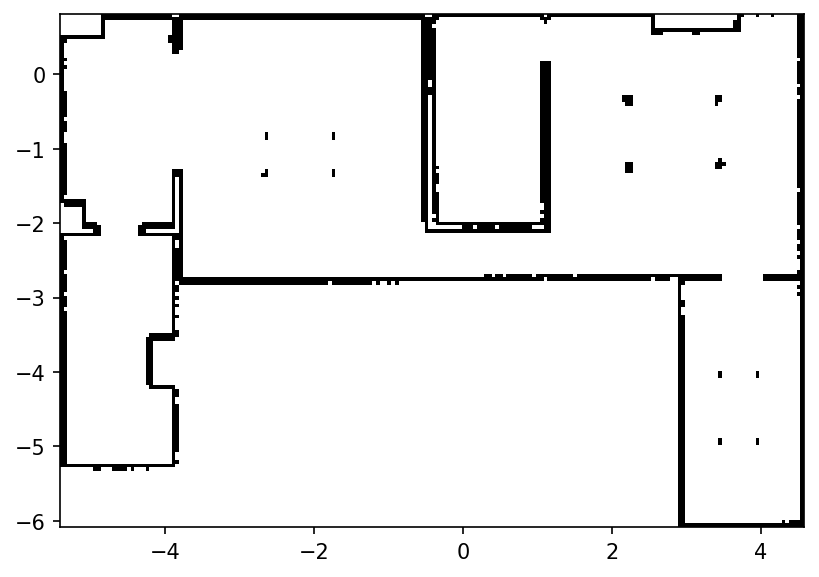

In [1]:
from PIL import Image, ImageOps

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import yaml
import pandas as pd

from copy import copy, deepcopy
import time

class Map():
    def __init__(self, map_name):
        self.map_im, self.map_df, self.limits = self.__open_map(map_name)
        self.image_array = self.__get_obstacle_map(self.map_im, self.map_df)

    def __repr__(self):
        fig, ax = plt.subplots(dpi=150)
        ax.imshow(self.image_array,extent=self.limits, cmap=cm.gray)
        ax.plot()
        return ""

    def __open_map(self, map_name):
        # Open the YAML file which contains the map name and other
        # configuration parameters
        f = open(map_name + '.yaml', 'r')
        map_df = pd.json_normalize(yaml.safe_load(f))
        # Open the map image
        map_name = map_df.image[0]
        im = Image.open(map_name)
        # im_size_old = im.size
        # print(im.size)
        size = 200, 200
        im.thumbnail(size)
        # print(im.size)

        # res_old = map_df.resolution[0]
        # print(res_old)
        # res_new = res_old * (im_size_old[0] / im.size[0])  # used width
        # print(res_new)
        # res_new = res_old * (im_size_old[1] / im.size[1])  # used height
        # print(res_new)

        im = ImageOps.grayscale(im)
        # Get the limits of the map. This will help to display the map
        # with the correct axis ticks.
        xmin = map_df.origin[0][0]
        xmax = map_df.origin[0][0] + im.size[0] * map_df.resolution[0]
        ymin = map_df.origin[0][1]
        ymax = map_df.origin[0][1] + im.size[1] * map_df.resolution[0]

        return im, map_df, [xmin, xmax, ymin, ymax]

    def __get_obstacle_map(self, map_im, map_df):
        img_array = np.reshape(list(self.map_im.getdata()), (self.map_im.size[1], self.map_im.size[0]))
        up_thresh = self.map_df.occupied_thresh[0]*255
        low_thresh = self.map_df.free_thresh[0]*255

        for j in range(self.map_im.size[0]):
            for i in range(self.map_im.size[1]):
                if img_array[i,j] > up_thresh:
                    img_array[i,j] = 255
                else:
                    img_array[i,j] = 0
        return img_array

mp = Map('sync_classroom_map')
print(mp)
# mp = Map('classroom_map')
# print(mp)

In [2]:
mp.image_array[:2]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255

In [3]:
mp.image_array.shape

(138, 200)

In [4]:
len(mp.image_array)

138

In [5]:
mp.image_array[0].size

200

In [6]:
mp.map_im.size

(200, 138)

## Graph Representation and Map Conversion
In order to make use of any of the path planning algorithms, it is important to convert the obtained map into a more useful notation. In general, the path planning algorithms work on the basis of a data structure called Graph. A graph is an abstract data type that consists of a finite set of vertices (nodes) and edges that connects them. The edges can have or not direction, which makes the graph directed or undirected respectively. Additionally, it is common to see values associated to the edges, which brings the concept of "cost" or "weight" to the graph.

The main objective is then to implement a processing tool capable of converting the image map representation into a graph, and then solve the planning problem from the map graph representation.

### Node/Tree Visualization
A useful tool for graph visualization is Graphviz, which can be used through the ``` edge ``` and ``` node ``` APIs to create a graph structure as the one shown below.

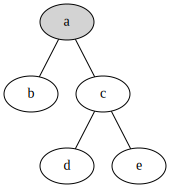

In [7]:
from graphviz import Graph
g = Graph('G')

g.node('a', 'a', style='filled')
g.node('b', 'b')
g.node('c', 'c')
g.node('d', 'd')
g.node('e', 'e')

g.edge('a', 'b', shape='none')
g.edge('a', 'c')
g.edge('c', 'd')
g.edge('c', 'e')

g

In [8]:
class Queue():
    def __init__(self, init_queue = []):
        self.queue = copy(init_queue)
        self.start = 0
        self.end = len(self.queue)-1

    def __len__(self):
        numel = len(self.queue)
        return numel

    def __repr__(self):
        q = self.queue
        tmpstr = ""
        for i in range(len(self.queue)):
            flag = False
            if(i == self.start):
                tmpstr += "<"
                flag = True
            if(i == self.end):
                tmpstr += ">"
                flag = True

            if(flag):
                tmpstr += '| ' + str(q[i]) + '|\n'
            else:
                tmpstr += ' | ' + str(q[i]) + '|\n'

        return tmpstr

    def __call__(self):
        return self.queue

    def initialize_queue(self, init_queue = []):
        self.queue = copy(init_queue)

    def sort(self, key=str.lower):
        self.queue = sorted(self.queue, key=key)

    def push(self, data):
        self.queue.append(data)
        self.end += 1

    def pop(self):
        p = self.queue.pop(self.start)
        self.end = len(self.queue)-1
        return p

class Node():
    def __init__(self, name):
        self.name = name
        self.pose = tuple(map(int, self.name.split(','))) if ',' in self.name else self.name
        self.children = []
        self.weight = []

    def __repr__(self):
        return self.name

    def add_children(self, node, w=None):
        if w == None:
            w = [1]*len(node)
        self.children.extend(node)
        self.weight.extend(w)

class Tree():
    def __init__(self, name):
        self.name = name
        self.root = 0
        self.end = 0
        self.g = {}
        self.g_visual = Graph('G')

    def __call__(self):
        for name, node in self.g.items():
            if(self.root == name):
                self.g_visual.node(name, name, color='red')
            elif(self.end == name):
                self.g_visual.node(name, name, color='blue')
            else:
                self.g_visual.node(name, name)

            for i in range(len(node.children)):
                c = node.children[i]
                w = node.weight[i]
                #print('%s -> %s'%(name,c.name))
                if w == 0:
                    self.g_visual.edge(name, c.name)
                else:
                    self.g_visual.edge(name, c.name, label=str(w))
        return self.g_visual

    def add_node(self, node, start = False, end = False):
        self.g[node.name] = node
        if(start):
            self.root = node.name
        elif(end):
            self.end = node.name

    def set_as_root(self, node):
        # These are exclusive conditions
        self.root = True
        self.end = False

    def set_as_end(self, node):
        # These are exclusive conditions
        self.root = False
        self.end = True


In [9]:
a = Node('a')
b = Node('b')
c = Node('c')
d = Node('d')
e = Node('e')
f = Node('f')

a.add_children([c], [1])
b.add_children([c, e], [1, 1])
c.add_children([b, e, d], [1, 3, 1])
e.add_children([b, c], [1, 3])
d.add_children([c], [1])

tree = Tree('tree')
tree.add_node(a, start=True)
tree.add_node(b)
tree.add_node(c)
tree.add_node(d)
tree.add_node(e, end=True)
tree.add_node(f)

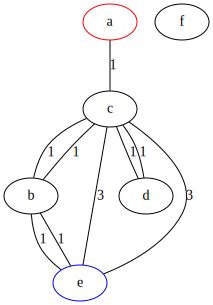

In [10]:
tree()

## Breadth First Search Algorithm

The breadth first search goes through the nodes in an unweighted graph and keeps a queue of the visited and unvisited nodes. For that, BFS checks the child nodes at every iteration and adds them to the queue, if a particular child node was already in the queue, it just skips to the next. At the end of the iteration, the parent node is marked as visited and it goes to the next entry in the queue. In the graph above, if we consider the node 'a' as the start node, then the queue would look like this after the first iteration.<br><br>
**1st iteration**
```
c
a <- visited
```
**2nd iteration**
```
d
e
b
c <- visited
a <- visited
```
**3rd iteration**
```
d
e
b <- visited
c <- visited
a <- visited
```

In [11]:
class BFS():
    def __init__(self, tree):
        self.q = Queue()
        self.visited = {name:False for name, node in tree.g.items()}
        self.via = {name:0 for name, node in tree.g.items()}
        self.dist = {name:0 for name, node in tree.g.items()}

    ## From SN to all Leaf Nodes
    def solve(self, sn): # sn -> start node
        self.q.push(sn)
        self.visited[sn.name] = True
        while len(self.q) > 0:
            node = self.q.pop()
            for i in range(len(node.children)):
                c = node.children[i]
                w = node.weight[i]
                if self.visited[c.name] == False:
                    self.q.push(c)
                    self.visited[c.name] = True
                    self.via[c.name] = node.name
                    self.dist[c.name] = self.dist[node.name] + w
            #print(node.name,self.q.queue)
            #print(self.dist)
        return self.via

    def reconstruct_path(self, sn=0, en=0):  # sn -> start node; en -> end node
        path = []
        node = en.name
        path.append(node)
        dist = self.dist[en.name]
        while True:
            node = self.via[node]
            if node == 0:
                break
            else:
                path.append(node)
        path.reverse()
        if path[0] != sn.name:
            path = []
        return path, dist


In [12]:
bfs = BFS(tree)
bfs.solve(tree.g[tree.root])
path, dist = bfs.reconstruct_path(tree.g[tree.root], tree.g[tree.end])
print(path)
print(dist)

['a', 'c', 'e']
4


## Dijkstra's Algorithm

Dijkstra's finds the shortest path between two points given a weighted graph. Unlike BFS, Dijkstra's algorithm takes into consideration how difficult is to get from one node to another. Once we pass the graph and the start point to the algorithm it will build a data structure, where we can find the shortest path from the given start point to any other node in the graph (if they are connected). If we only require to find the path to one end point, then the algorithm can be shortened to break once that end point is found.

The key difference of this algorithms lies on the ``` dist ``` and ``` via ``` lists, which give the ability to propritize the search of the shortest path. This also has the disadvantage that, if no other information is given, the algorithm will start looking for the shortest edges, regardless of where the target/end node is.

In [13]:
a = Node('a')
b = Node('b')
c = Node('c')
d = Node('d')
e = Node('e')
f = Node('f')

a.add_children([c], [1])
b.add_children([c, e], [1, 1])
c.add_children([b, e, d], [1, 3, 1])
e.add_children([b, c], [1, 3])
d.add_children([c], [1])

tree = Tree('tree1')
tree.add_node(a, start=True)
tree.add_node(b)
tree.add_node(c)
tree.add_node(d)
tree.add_node(e, end=True)
tree.add_node(f)

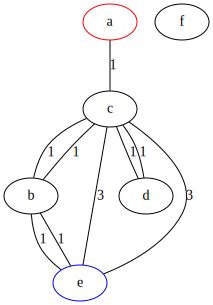

In [14]:
tree()

In [15]:
class Dijkstra():
    def __init__(self, in_tree):
        self.q = Queue()
        ## wrt SN
        self.dist = {name:np.inf for name, node in in_tree.g.items()}
        ## wrt SN
        self.via = {name:0 for name, node in in_tree.g.items()}
        # self.visited = {name:False for name, node in in_tree.g.items()}
        for __, node in in_tree.g.items():
            self.q.push(node)

    def __get_dist_to_node(self, node):
        return self.dist[node.name]

    ## From SN to all Leaf Nodes with considering weights and distance
    def solve(self, sn, en):
        ## assigning the dist for the start node to zero to start the solve from it
        self.dist[sn.name] = 0
        while len(self.q) > 0:
            self.q.sort(key=self.__get_dist_to_node)
            u = self.q.pop()
            #print(u.name,self.q.queue)
            ## to not traverse after the end node point
            if u.name == en.name:
                break
            ## from the node with shortest distance to its children
            for i in range(len(u.children)):
                c = u.children[i]
                w = u.weight[i]
                new_dist = self.dist[u.name] + w
                if new_dist < self.dist[c.name]:
                    self.dist[c.name] = new_dist
                    self.via[c.name] = u.name

    def reconstruct_path(self, sn, en):
        start_key = sn.name
        end_key = en.name
        dist = self.dist[end_key]
        u = end_key
        path = [u]
        while u != start_key:
            u = self.via[u]
            path.append(u)
        path.reverse()
        return path, dist


In [16]:
dj = Dijkstra(tree)
dj.solve(tree.g[tree.root], tree.g[tree.end])
dj.reconstruct_path(tree.g[tree.root], tree.g[tree.end])

(['a', 'c', 'b', 'e'], 3)

## A* Algorithm
A* can be seen as an extension of Dijkstra's algorithm. While Dijkstra's fails to do a "smart" search, A* introduces an heuristic function $h$ to provide more information to the search process, which is aimed to improve the speed of Dijkstra's.
In other words, the search queue in A* is prioritized based on a function $f(n)=g(n)+h(n)$, where $g(n)$ is the ``` dist ```
vector containing the shortest distance up to the node $n$, while $h(n)$ is an heuristic that provides an idea of how "good" is to move to the node $n$ while searching for the path. Thus the score function $f$ weights not just how close is the node $n$ from the current node, but how "good" is to move towards that point, which at the end helps to proritize the paths that make more sense.

In [17]:
# class AStar():
#     def __init__(self, in_tree):
#         self.in_tree = in_tree
#         self.q = Queue()
#         self.dist = {name:np.inf for name, node in in_tree.g.items()}
#         self.h = {name:0 for name, node in in_tree.g.items()}

#         ## From every node to the end node distance in terms of coordinates or pixels on the image
#         for name, node in in_tree.g.items():
#             start = tuple(map(int, name.split(',')))
#             end = tuple(map(int, self.in_tree.end.split(',')))
#             ## Heuristic in terms of Euclidean Distance
#             # self.h[name] = np.sqrt((end[0]-start[0])**2 + (end[1]-start[1])**2)
#             ## Heuristic in terms of Octile Distance
#             ## Use as many diagonals as possible, min(dx,dy) diagonals, then finish the leftover |dx-dy| steps straight
#             d = 1
#             dr2 = np.sqrt(2)
#             dx = abs(end[0]-start[0])
#             dy = abs(end[1]-start[1])
#             self.h[name] = d*(dx + dy) + (dr2-2*d)*(min(dx, dy))
#             # self.h[name] = d*max(dx, dy) + (dr2-d)*(min(dx, dy))
#             # self.h[name] = dr2*min(dx, dy) + d*(abs(dx-dy))
#             ## ToDo: Heuristic to factor other costs apart from distance such as,
#             ## time (bot's limitation in terms of manueverability and mobility),
#             ## space (proximity of bot to obstacles/safety distance from obstacles including the bot physical features like width/diameter), and
#             ## energy (fuel - gas/e-)
#             # self.h[name] = None

#         self.via = {name:0 for name, node in in_tree.g.items()}

#         # for __, node in in_tree.g.items():
#         #     self.q.push(node)

#         self.path_as = []
#         self.dist_as = None

#     def __init_q(self, sn):
#         self.q.push(sn)
#         ## assigning the dist for the start node to zero to start the solve from it
#         self.dist[sn.name] = 0

#     def __get_f_score(self, node):
#         idx = node.name
#         ## upto the node distace + from the node to the end node heuristic
#         return self.dist[idx] + self.h[idx]

#     ## From SN to all Leaf Nodes with considering weights+heuristic and distance
#     def solve(self, sn, en):
#         ## Push the start node to the queue and initialize the distance to 0
#         # self.__init_q(sn)
#         ## assigning the dist for the start node to zero to start the solve from it
#         self.dist[sn.name] = 0

#         pn = sn
#         reached_en = False
#         self.path_as.append(sn.name)
#         while not reached_en:
#             print(f'\n\n\n==== {pn.name} ====\n')
#             ## Sort the queue based on the f score
#             # self.q.sort(key=self.__get_f_score)
#             # pn = self.q.pop()  ## pn is parent node
#             #print(u.name,self.q.queue)
#             ## to not traverse after the end node point
#             # if pn.name == en.name:
#             #     break
#             ## from the node with shortest distance to its children
#             shortest_fscore_from_pn_2_cn_2_en = None
#             shortest_fscore_from_pn_2_cn_2_en_node = None
#             for i in range(len(pn.children)):
#                 cn = pn.children[i]
#                 cw = pn.weight[i]
#                 print(f'-- {cn.name} --')
#                 new_dist = self.dist[pn.name] + cw
#                 f_score = new_dist + self.h[cn.name]
#                 print(f'f_score: {f_score}')
#                 if shortest_fscore_from_pn_2_cn_2_en == None:
#                   shortest_fscore_from_pn_2_cn_2_en = f_score
#                   shortest_fscore_from_pn_2_cn_2_en_node = cn
#                 else:
#                     if f_score < shortest_fscore_from_pn_2_cn_2_en:
#                         shortest_fscore_from_pn_2_cn_2_en = f_score
#                         shortest_fscore_from_pn_2_cn_2_en_node = cn
#                 self.dist[cn.name] = new_dist
#                 if cn.name == en.name:
#                     reached_en = True
#                     self.via[cn.name] = pn.name
#                     break
#             if shortest_fscore_from_pn_2_cn_2_en_node != None:
#                 # self.q.push(shortest_fscore_from_pn_2_cn_2_en_node)
#                 self.path_as.append(shortest_fscore_from_pn_2_cn_2_en_node.name)
#                 self.dist_as = self.dist[shortest_fscore_from_pn_2_cn_2_en_node.name]
#                 self.via[shortest_fscore_from_pn_2_cn_2_en_node.name] = pn.name
#                 pn = shortest_fscore_from_pn_2_cn_2_en_node

#             path_arr_as = mp.draw_path(self.path_as)
#             fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi=300, sharex=True, sharey=True)
#             ax.imshow(path_arr_as)
#             ax.set_title('Path A*')
#             plt.show()

#     def reconstruct_path(self, sn, en):
#         start_key = sn.name
#         end_key = en.name
#         dist = self.dist[end_key]
#         u = end_key
#         path = [u]
#         while u != start_key:
#             u = self.via[u]
#             path.append(u)
#         path.reverse()
#         return path, dist

In [18]:
# class AStar():
#     def __init__(self, in_tree):
#         self.in_tree = in_tree
#         self.q = Queue()
#         self.closed_set = set()
#         self.dist = {name:np.inf for name, node in in_tree.g.items()}
#         self.h = {name:0 for name, node in in_tree.g.items()}

#         ## From every node to the end node distance in terms of coordinates or pixels on the image
#         for name, node in self.in_tree.g.items():
#             # start = tuple(map(int, name.split(',')))
#             # end = tuple(map(int, self.in_tree.end.split(',')))
#             start = node.pose
#             end = self.in_tree.g[self.in_tree.end].pose
#             ## Heuristic in terms of Euclidean Distance
#             # self.h[name] = np.sqrt((end[0]-start[0])**2 + (end[1]-start[1])**2)
#             ## Heuristic in terms of Octile Distance
#             ## Use as many diagonals as possible, min(dx,dy) diagonals, then finish the leftover |dx-dy| steps straight
#             d = 1
#             dr2 = np.sqrt(2)
#             dx = abs(end[0]-start[0])
#             dy = abs(end[1]-start[1])
#             self.h[name] = d*(dx + dy) + (dr2-2*d)*(min(dx, dy))
#             # self.h[name] = d*max(dx, dy) + (dr2-d)*(min(dx, dy))
#             # self.h[name] = dr2*min(dx, dy) + d*(abs(dx-dy))
#             ## ToDo: Heuristic to factor other costs apart from distance such as,
#             ## time (bot's limitation in terms of manueverability and mobility),
#             ## space (proximity of bot to obstacles/safety distance from obstacles including the bot physical features like width/diameter), and
#             ## energy (fuel - gas/e-)
#             # self.h[name] = None

#         self.via = {name:0 for name, node in in_tree.g.items()}

#         # for __, node in in_tree.g.items():
#         #     self.q.push(node)

#     def __init_q(self, sn):
#         self.q.push(sn)
#         ## assigning the dist for the start node to zero to start the solve from it
#         self.dist[sn.name] = 0

#     def __get_f_score(self, node):
#         idx = node.name
#         ## upto the node distace + from the node to the end node heuristic
#         return self.dist[idx] + self.h[idx]

#     ## From SN to all Leaf Nodes with considering weights+heuristic and distance
#     def solve(self, sn, en):
#         ## Push the start node to the queue and initialize the distance to 0
#         self.__init_q(sn)

#         while len(self.q) > 0:
#             ## Sort the queue based on the f score
#             self.q.sort(key=self.__get_f_score)
#             pn = self.q.pop()  ## pn is parent node
#             if pn.name in self.closed_set:
#                 continue
#             self.closed_set.add(pn.name)
#             #print(u.name,self.q.queue)
#             ## to not traverse after the end node point
#             if pn.name == en.name:
#                 break
#             ## from the node with shortest distance to its children
#             for i in range(len(pn.children)):
#                 cn = pn.children[i]
#                 cw = pn.weight[i]
#                 new_dist = self.dist[pn.name] + cw
#                 if new_dist < self.dist[cn.name]:
#                     self.dist[cn.name] = new_dist
#                     self.via[cn.name] = pn.name
#                     self.q.push(cn)

#     def reconstruct_path(self, sn, en):
#         start_key = sn.name
#         end_key = en.name
#         dist = self.dist[end_key]
#         u = end_key
#         path = [u]
#         while u != start_key:
#             u = self.via[u]
#             path.append(u)
#         path.reverse()
#         return path, dist

In [19]:
import heapq
import itertools

In [20]:
class AStar():
    def __init__(self, in_tree):
        self.in_tree = in_tree
        self._counter = itertools.count()  # tie-breaker to keep heap stable
        self.open_hq = []
        self.closed_set = set()
        self.dist = {name:np.inf for name, node in in_tree.g.items()}
        self.h = {name:0 for name, node in in_tree.g.items()}

        ## From every node to the end node distance in terms of coordinates or pixels on the image
        for name, node in self.in_tree.g.items():
            # start = tuple(map(int, name.split(',')))
            # end = tuple(map(int, self.in_tree.end.split(',')))
            start = node.pose
            end = self.in_tree.g[self.in_tree.end].pose
            ## Heuristic in terms of Euclidean Distance
            # self.h[name] = np.sqrt((end[0]-start[0])**2 + (end[1]-start[1])**2)
            ## Heuristic in terms of Octile Distance
            ## Use as many diagonals as possible, min(dx,dy) diagonals, then finish the leftover |dx-dy| steps straight
            d = 1
            dr2 = np.sqrt(2)
            dx = abs(end[0]-start[0])
            dy = abs(end[1]-start[1])
            self.h[name] = d*(dx + dy) + (dr2-2*d)*(min(dx, dy))
            # self.h[name] = d*max(dx, dy) + (dr2-d)*(min(dx, dy))
            # self.h[name] = dr2*min(dx, dy) + d*(abs(dx-dy))
            ## ToDo: Heuristic to factor other costs apart from distance such as,
            ## time (bot's limitation in terms of manueverability and mobility),
            ## space (proximity of bot to obstacles/safety distance from obstacles including the bot physical features like width/diameter), and
            ## energy (fuel - gas/e-)
            # self.h[name] = None

        self.via = {name:0 for name, node in in_tree.g.items()}

        # for __, node in in_tree.g.items():
        #     self.q.push(node)

    def __init_hq(self, sn):
        heapq.heappush(self.open_hq, (self.__get_f_score(sn), next(self._counter), sn.name))
        ## assigning the dist for the start node to zero to start the solve from it
        self.dist[sn.name] = 0

    def __get_f_score(self, node):
        idx = node.name
        ## upto the node distace + from the node to the end node heuristic
        return self.dist[idx] + self.h[idx]

    ## From SN to all Leaf Nodes with considering weights+heuristic and distance
    def solve(self, sn, en):
        ## Initialize Open Heap Queue with Start Node and update Start Node distance value with 0
        self.__init_hq(sn)

        while self.open_hq:
            _, _, pn_name = heapq.heappop(self.open_hq)  ## pn is parent node

            if pn_name in self.closed_set:
                continue
            self.closed_set.add(pn_name)

            ## to not traverse after the end node point
            if pn_name == en.name:
                break

            pn = self.in_tree.g[pn_name]
            ## from the node with shortest distance to its children
            for i in range(len(pn.children)):
                cn = pn.children[i]
                cw = pn.weight[i]
                new_dist = self.dist[pn.name] + cw
                if new_dist < self.dist[cn.name]:
                    self.dist[cn.name] = new_dist
                    self.via[cn.name] = pn.name
                    heapq.heappush(self.open_hq, (self.__get_f_score(cn), next(self._counter), cn.name))

    def reconstruct_path(self, sn, en):
        start_key = sn.name
        end_key = en.name
        dist = self.dist[end_key]
        u = end_key
        path = [u]
        while u != start_key:
            u = self.via[u]
            path.append(u)
        path.reverse()
        return path, dist

## Create A Graph From A Map

In [21]:
class MapProcessor():
    def __init__(self, name):
        self.map = Map(name)
        self.inf_map_img_array = np.zeros(self.map.image_array.shape)
        self.map_graph = Tree(name)

    def __modify_map_pixel(self, map_array, i, j, value, absolute):
        if( (i >= 0) and
            (i < map_array.shape[0]) and
            (j >= 0) and
            (j < map_array.shape[1]) ):
            if absolute:
                map_array[i][j] = value
            else:
                map_array[i][j] += value

    def __inflate_obstacle(self, kernel, map_array, i, j, absolute):
        dx = int(kernel.shape[0]//2)
        dy = int(kernel.shape[1]//2)
        if (dx == 0) and (dy == 0):
            self.__modify_map_pixel(map_array, i, j, kernel[0][0], absolute)
        else:
            for k in range(i-dx, i+dx):
                for l in range(j-dy, j+dy):
                    self.__modify_map_pixel(map_array, k, l, kernel[k-i+dx][l-j+dy], absolute)

    def inflate_map(self, kernel, absolute=True):
        ## Normalization of map-obstacles
        # Perform an operation like dilation, such that the small wall found during the mapping process
        # are increased in size, thus forcing a safer path.
        self.inf_map_img_array = np.zeros(self.map.image_array.shape)
        for i in range(self.map.image_array.shape[0]):
            for j in range(self.map.image_array.shape[1]):
                if self.map.image_array[i][j] == 0:
                    self.__inflate_obstacle(kernel, self.inf_map_img_array, i, j, absolute)
        r = np.max(self.inf_map_img_array)-np.min(self.inf_map_img_array)
        if r == 0:
            r = 1
        self.inf_map_img_array = (self.inf_map_img_array - np.min(self.inf_map_img_array))/r

    def get_graph_from_map(self):
        # Create the nodes that will be part of the graph, considering only valid nodes or the free space
        for i in range(self.map.image_array.shape[0]):
            for j in range(self.map.image_array.shape[1]):
                if self.inf_map_img_array[i][j] == 0:
                    node = Node('%d,%d'%(i,j))
                    self.map_graph.add_node(node)

        # Connect the nodes through edges
        for i in range(self.map.image_array.shape[0]):
            for j in range(self.map.image_array.shape[1]):
                if self.inf_map_img_array[i][j] == 0:
                    if (i > 0):
                        if self.inf_map_img_array[i-1][j] == 0:
                            # add an edge up
                            child_up = self.map_graph.g['%d,%d'%(i-1, j)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_up], [1])
                    if (i < (self.map.image_array.shape[0] - 1)):
                        if self.inf_map_img_array[i+1][j] == 0:
                            # add an edge down
                            child_dw = self.map_graph.g['%d,%d'%(i+1, j)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_dw], [1])
                    if (j > 0):
                        if self.inf_map_img_array[i][j-1] == 0:
                            # add an edge to the left
                            child_lf = self.map_graph.g['%d,%d'%(i, j-1)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_lf], [1])
                    if (j < (self.map.image_array.shape[1] - 1)):
                        if self.inf_map_img_array[i][j+1] == 0:
                            # add an edge to the right
                            child_rg = self.map_graph.g['%d,%d'%(i, j+1)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_rg], [1])
                    if ((i > 0) and (j > 0)):
                        if self.inf_map_img_array[i-1][j-1] == 0:
                            # add an edge up-left
                            child_up_lf = self.map_graph.g['%d,%d'%(i-1, j-1)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_up_lf],
                                                                          [np.sqrt(2)]
                                                                          # [0.5]  ## [Does not work] Making diagnols have lesser weight for smooth and direct movement, configuration specific for A*
                                                                          )
                    if ((i > 0) and (j < (self.map.image_array.shape[1] - 1))):
                        if self.inf_map_img_array[i-1][j+1] == 0:
                            # add an edge up-right
                            child_up_rg = self.map_graph.g['%d,%d'%(i-1, j+1)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_up_rg],
                                                                          [np.sqrt(2)]
                                                                          # [0.5]  ## [Does not work] Making diagnols have lesser weight for smooth and direct movement, configuration specific for A*
                                                                          )
                    if ((i < (self.map.image_array.shape[0] - 1)) and (j > 0)):
                        if self.inf_map_img_array[i+1][j-1] == 0:
                            # add an edge down-left
                            child_dw_lf = self.map_graph.g['%d,%d'%(i+1, j-1)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_dw_lf],
                                                                          [np.sqrt(2)]
                                                                          # [0.5]  ## [Does not work] Making diagnols have lesser weight for smooth and direct movement, configuration specific for A*
                                                                          )
                    if ((i < (self.map.image_array.shape[0] - 1)) and (j < (self.map.image_array.shape[1] - 1))):
                        if self.inf_map_img_array[i+1][j+1] == 0:
                            # add an edge down-right
                            child_dw_rg = self.map_graph.g['%d,%d'%(i+1, j+1)]
                            self.map_graph.g['%d,%d'%(i, j)].add_children([child_dw_rg],
                                                                          [np.sqrt(2)]
                                                                          # [0.5]  ## [Does not work] Making diagnols have lesser weight for smooth and direct movement, configuration specific for A*
                                                                          )

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        r = np.max(g)-np.min(g)
        sm = (g - np.min(g))*1/r
        return sm

    def rect_kernel(self, size, value):
        m = np.ones(shape=(size,size))
        return m

    def draw_path(self, path):
        path_tuple_list = []
        path_array = copy(self.inf_map_img_array)
        for idx in path:
            tup = tuple(map(int, idx.split(',')))
            path_tuple_list.append(tup)
            path_array[tup] = 0.5
        return path_array

In [22]:
mp = MapProcessor('sync_classroom_map')
# mp = MapProcessor('classroom_map')

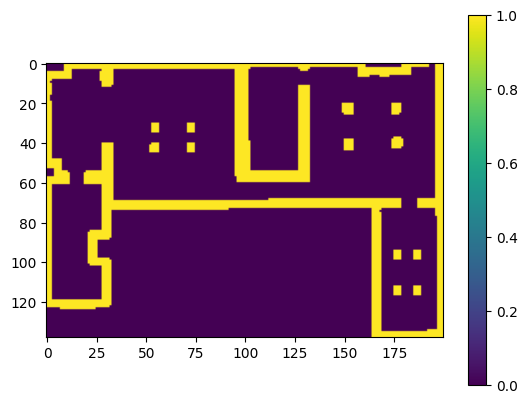

In [23]:
kr = mp.rect_kernel(5, 1)
#kr = mp.rect_kernel(1, 1)
mp.inflate_map(kr, True)

mp.get_graph_from_map()

fig, ax = plt.subplots(dpi=100)
plt.imshow(mp.inf_map_img_array)
plt.colorbar()
plt.show()

In [31]:
# mp.map_graph.root = "150,25"
# mp.map_graph.end = "200,275"

mp.map_graph.root = "100,12"
mp.map_graph.end = "130,180"

# mp.map_graph.root = "100,12"
# mp.map_graph.end = "50,112"

# mp.map_graph.root = "10,20"
# mp.map_graph.end = "10,185"

# mp.map_graph.root = "30,8"
# mp.map_graph.end = "35,45"

start = time.time()
bfs_maze = BFS(mp.map_graph)
end = time.time()
print('Elapsed Init Time: %.10f'%(end - start))

start = time.time()
bfs_maze.solve(mp.map_graph.g[mp.map_graph.root])
end = time.time()
print('Elapsed Solve Time: %.5f'%(end - start))

path_bfs, dist_bfs = bfs_maze.reconstruct_path(mp.map_graph.g[mp.map_graph.root], mp.map_graph.g[mp.map_graph.end])

Elapsed Init Time: 0.0144400597
Elapsed Solve Time: 0.03418


In [32]:
path_arr_bfs = mp.draw_path(path_bfs)

In [33]:
path_bfs

['100,12',
 '99,12',
 '98,12',
 '97,12',
 '96,12',
 '95,12',
 '94,12',
 '93,12',
 '92,12',
 '91,12',
 '90,12',
 '89,12',
 '88,12',
 '87,12',
 '86,12',
 '85,12',
 '84,12',
 '83,12',
 '82,12',
 '81,12',
 '80,12',
 '79,12',
 '78,12',
 '77,12',
 '76,12',
 '75,12',
 '74,12',
 '73,12',
 '72,12',
 '71,12',
 '70,12',
 '69,12',
 '68,12',
 '67,12',
 '66,12',
 '65,12',
 '64,12',
 '63,12',
 '62,12',
 '61,12',
 '60,12',
 '59,12',
 '58,12',
 '57,12',
 '56,12',
 '55,12',
 '54,13',
 '53,14',
 '52,15',
 '51,16',
 '50,17',
 '49,18',
 '48,19',
 '47,20',
 '46,21',
 '45,22',
 '44,23',
 '43,24',
 '42,25',
 '41,26',
 '40,27',
 '39,28',
 '39,29',
 '39,30',
 '39,31',
 '39,32',
 '39,33',
 '39,34',
 '39,35',
 '39,36',
 '39,37',
 '39,38',
 '39,39',
 '39,40',
 '39,41',
 '39,42',
 '39,43',
 '39,44',
 '39,45',
 '39,46',
 '39,47',
 '39,48',
 '39,49',
 '39,50',
 '39,51',
 '39,52',
 '39,53',
 '39,54',
 '39,55',
 '39,56',
 '39,57',
 '39,58',
 '39,59',
 '39,60',
 '39,61',
 '39,62',
 '39,63',
 '39,64',
 '39,65',
 '39,66',

In [34]:
# mp.map_graph.root = "150,25"
# mp.map_graph.end = "200,275"

mp.map_graph.root = "100,12"
mp.map_graph.end = "130,180"

# mp.map_graph.root = "100,12"
# mp.map_graph.end = "50,112"

# mp.map_graph.root = "10,20"
# mp.map_graph.end = "10,185"

# mp.map_graph.root = "30,8"
# mp.map_graph.end = "35,45"

start = time.time()
dj_maze = Dijkstra(mp.map_graph)
end = time.time()
print('Elapsed Init Time: %.10f'%(end - start))

start = time.time()
dj_maze.solve(mp.map_graph.g[mp.map_graph.root], mp.map_graph.g[mp.map_graph.end])
end = time.time()
print('Elapsed Solve Time: %.5f'%(end - start))

path_djk, dist_djk = dj_maze.reconstruct_path(mp.map_graph.g[mp.map_graph.root], mp.map_graph.g[mp.map_graph.end])

Elapsed Init Time: 0.0069334507
Elapsed Solve Time: 23.97576


In [35]:
path_arr_djk = mp.draw_path(path_djk)

In [36]:
path_djk

['100,12',
 '99,12',
 '98,12',
 '97,12',
 '96,12',
 '95,12',
 '94,12',
 '93,12',
 '92,12',
 '91,12',
 '90,12',
 '89,12',
 '88,12',
 '87,12',
 '86,12',
 '85,12',
 '84,12',
 '83,12',
 '82,12',
 '81,12',
 '80,12',
 '79,12',
 '78,12',
 '77,12',
 '76,12',
 '75,12',
 '74,12',
 '73,12',
 '72,12',
 '71,12',
 '70,12',
 '69,12',
 '68,12',
 '67,12',
 '66,12',
 '65,12',
 '64,12',
 '63,12',
 '62,12',
 '61,12',
 '60,12',
 '59,12',
 '58,12',
 '57,12',
 '56,12',
 '55,12',
 '54,13',
 '53,14',
 '52,15',
 '51,16',
 '50,17',
 '49,18',
 '48,19',
 '47,20',
 '46,21',
 '45,22',
 '44,23',
 '43,24',
 '42,25',
 '41,26',
 '40,27',
 '39,28',
 '39,29',
 '39,30',
 '39,31',
 '39,32',
 '39,33',
 '39,34',
 '39,35',
 '39,36',
 '39,37',
 '39,38',
 '39,39',
 '39,40',
 '39,41',
 '39,42',
 '39,43',
 '39,44',
 '39,45',
 '39,46',
 '40,47',
 '41,48',
 '42,49',
 '43,50',
 '44,51',
 '45,52',
 '45,53',
 '45,54',
 '45,55',
 '45,56',
 '46,57',
 '47,58',
 '48,59',
 '49,60',
 '50,61',
 '51,62',
 '52,63',
 '53,64',
 '54,65',
 '55,66',

In [37]:
# mp.map_graph.root = "150,25"
# mp.map_graph.end = "200,275"

mp.map_graph.root = "100,12"
mp.map_graph.end = "130,180"

# mp.map_graph.root = "100,12"
# mp.map_graph.end = "50,112"

# mp.map_graph.root = "10,20"
# mp.map_graph.end = "10,185"

# mp.map_graph.root = "30,8"
# mp.map_graph.end = "35,45"

start = time.time()
as_maze = AStar(mp.map_graph)
end = time.time()
print('Elapsed Init Time: %.3f'%(end - start))

start = time.time()
as_maze.solve(mp.map_graph.g[mp.map_graph.root], mp.map_graph.g[mp.map_graph.end])
end = time.time()
print('Elapsed Solve Time: %.3f'%(end - start))

path_as, dist_as = as_maze.reconstruct_path(mp.map_graph.g[mp.map_graph.root], mp.map_graph.g[mp.map_graph.end])

Elapsed Init Time: 0.058
Elapsed Solve Time: 0.031


In [38]:
path_arr_as = mp.draw_path(path_as)

In [39]:
path_as

['100,12',
 '99,13',
 '98,13',
 '97,13',
 '96,13',
 '95,13',
 '94,13',
 '93,13',
 '92,13',
 '91,13',
 '90,13',
 '89,13',
 '88,13',
 '87,13',
 '86,13',
 '85,13',
 '84,13',
 '83,13',
 '82,13',
 '81,13',
 '80,13',
 '79,13',
 '78,13',
 '77,13',
 '76,13',
 '75,13',
 '74,13',
 '73,13',
 '72,13',
 '71,13',
 '70,13',
 '69,13',
 '68,13',
 '67,14',
 '66,15',
 '65,16',
 '64,17',
 '63,18',
 '62,18',
 '61,18',
 '60,18',
 '59,18',
 '58,18',
 '57,18',
 '56,18',
 '55,18',
 '54,19',
 '53,20',
 '52,21',
 '51,22',
 '50,23',
 '49,24',
 '48,25',
 '47,26',
 '46,27',
 '45,27',
 '44,27',
 '43,27',
 '42,27',
 '41,27',
 '40,27',
 '39,28',
 '39,29',
 '39,30',
 '39,31',
 '39,32',
 '39,33',
 '40,34',
 '41,35',
 '42,36',
 '43,37',
 '44,38',
 '45,39',
 '46,40',
 '47,41',
 '48,42',
 '49,43',
 '50,44',
 '51,45',
 '52,46',
 '53,47',
 '54,48',
 '55,49',
 '56,50',
 '57,51',
 '58,52',
 '59,53',
 '60,54',
 '61,55',
 '62,56',
 '63,57',
 '64,58',
 '65,59',
 '65,60',
 '65,61',
 '65,62',
 '65,63',
 '65,64',
 '65,65',
 '65,66',

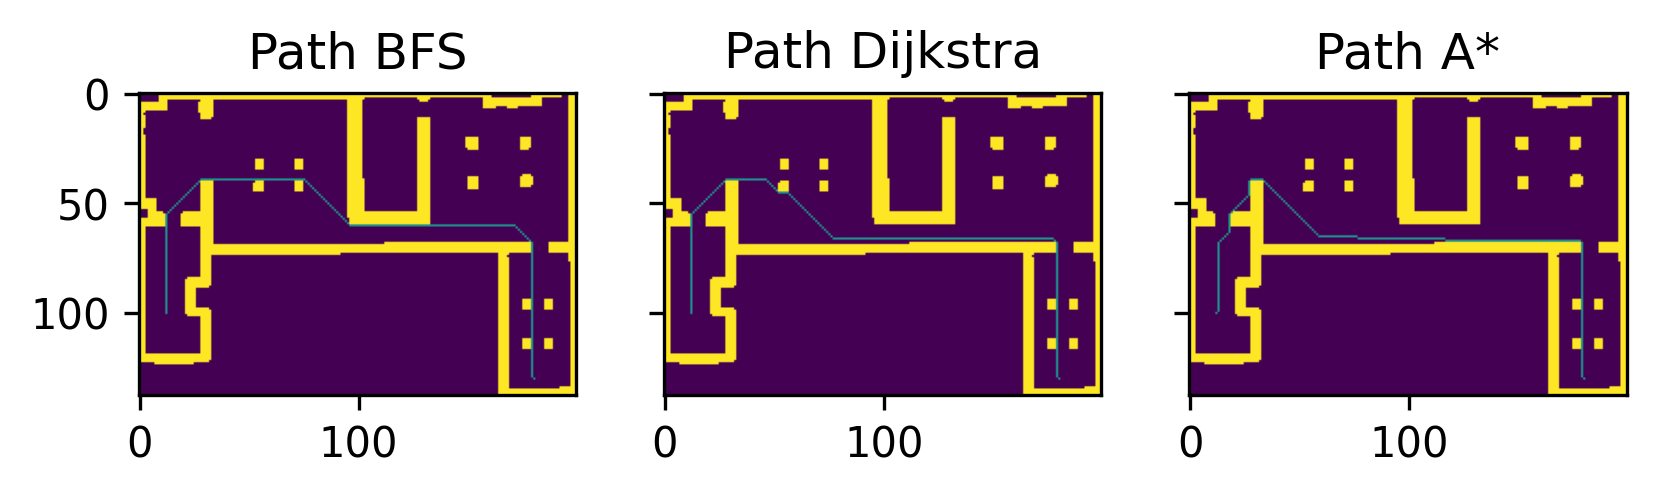

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, dpi=300, sharex=True, sharey=True)
# fig, ax = plt.subplots(nrows = 1, ncols = 2, dpi=300, sharex=True, sharey=True)
ax[0].imshow(path_arr_bfs)
ax[0].set_title('Path BFS')
ax[1].imshow(path_arr_djk)
ax[1].set_title('Path Dijkstra')
ax[2].imshow(path_arr_as)
ax[2].set_title('Path A*')

plt.show()

In [41]:
print(dist_bfs)
print(dist_djk)
print(dist_as)

293.05382386916256
293.0538238691623
293.0538238691623


In [ ]:
# For Grading Purposes ONLY (PLEASE DO NOT REMOVE)
from jupyter_grader import JupyterGrader
grader = JupyterGrader()
# Update the 'map_name' variable if your map filename is different
map_name = 'sync_classroom_map'
grader.test_map_creation(map_name)
grader.test_a_star(AStar)